### SVI

This code runs SVI, but not to convergence. It should be run on a small subset of the data. 

In [1]:
from matplotlib import pyplot as plt
from jax import numpy as jnp
import numpyro
numpyro.set_host_device_count(8)
import jax
import numpy as np
import pandas as pd
import os
import glob

from tfscreen.analysis.hierarchical.growth_model import GrowthModel
from tfscreen.analysis.hierarchical.run_inference import RunInference
from tfscreen.analysis.hierarchical.analyze_theta import _run_svi
import tfscreen

In [10]:


to_get_list = ["wt","M42I","H74A","K84L","I64N","L45P","I79C","T68V","A81C"]

growth_df = tfscreen.util.read_dataframe("growth.csv")
growth_df_subset = growth_df[growth_df["genotype"].isin(to_get_list)].reset_index(drop=True)

bind_df = tfscreen.util.read_dataframe("binding.csv")
bind_df_subset = bind_df[bind_df["genotype"].isin(to_get_list)].reset_index(drop=True)

gm = GrowthModel(growth_df=growth_df_subset,
                 binding_df=bind_df_subset,
                 batch_size=1024,
                 condition_growth="hierarchical",
                 ln_cfu0="hierarchical",
                 dk_geno="hierarchical",
                 activity="fixed",
                 theta="hill",
                 theta_binding_noise="none",
                 theta_growth_noise="none")

ri = RunInference(gm,seed=42)

for f in glob.glob("svi-tmp_*"): 
    os.remove(f)

svi_state, params, converged = _run_svi(ri,
                                        init_params=None,
                                        checkpoint_file=None,
                                        out_root="svi-tmp",
                                        adam_step_size=1e-6,
                                        adam_clip_norm=1.0,
                                        elbo_num_particles=10,
                                        convergence_tolerance=1e-6,
                                        convergence_window=2000,
                                        checkpoint_interval=1000,
                                        num_steps=100000,
                                        num_posterior_samples=10000,
                                        sampling_batch_size=100,
                                        forward_batch_size=512,
                                        always_get_posterior=False)

# This call forces getting posteriors
svi_state, params, converged = _run_svi(ri,
                                        init_params=None,
                                        checkpoint_file=None,
                                        out_root="svi-tmp",
                                        adam_step_size=1e-6,
                                        adam_clip_norm=1.0,
                                        elbo_num_particles=10,
                                        convergence_tolerance=1e-6,
                                        convergence_window=100,
                                        checkpoint_interval=10,
                                        num_steps=0,
                                        num_posterior_samples=5000,
                                        sampling_batch_size=100,
                                        forward_batch_size=512,
                                        always_get_posterior=True)

params = gm.extract_parameters("svi-tmp_posterior.npz")

Step:          0, Loss: 1.13778e+05, Change:        inf
Step:       1000, Loss: 1.07114e+05, Change:        inf
Step:       2000, Loss: 1.13167e+05, Change:        inf
Step:       3000, Loss: 1.21394e+05, Change:        inf
Step:       4000, Loss: 1.13469e+05, Change: 1.39667e-03
Step:       5000, Loss: 1.16688e+05, Change: 2.47549e-03
Step:       6000, Loss: 1.14305e+05, Change: 3.30184e-03
Step:       7000, Loss: 1.05046e+05, Change: 2.72018e-03
Step:       8000, Loss: 1.12494e+05, Change: 2.38934e-03
Step:       9000, Loss: 1.06396e+05, Change: 1.73650e-03
Step:      10000, Loss: 1.11332e+05, Change: 1.85791e-03
Step:      11000, Loss: 1.20780e+05, Change: 1.67580e-03
Step:      12000, Loss: 1.21149e+05, Change: 1.70304e-03
Step:      13000, Loss: 1.19702e+05, Change: 3.85697e-03
Step:      14000, Loss: 1.16215e+05, Change: 3.24013e-03
Step:      15000, Loss: 1.09368e+05, Change: 1.36100e-03
Step:      16000, Loss: 1.14795e+05, Change: 3.09793e-03
Step:      17000, Loss: 1.15217e+05

sampling posterior:   0%|          | 0/50 [00:00<?, ?it/s]

SVI run has not yet converged.


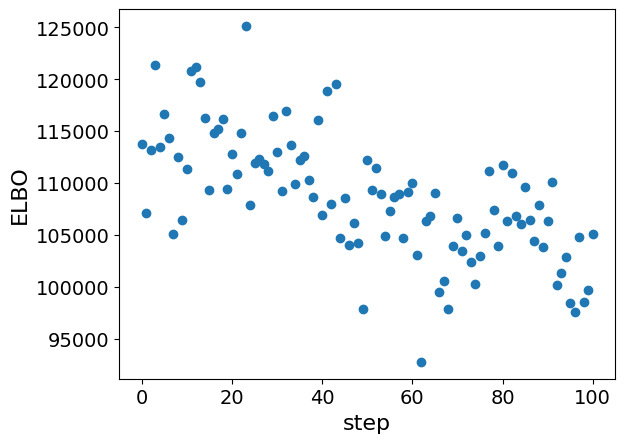

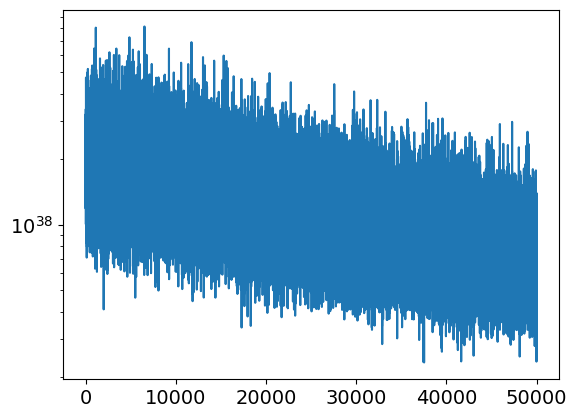

In [2]:

# Plot human readable losses
df = pd.read_csv("svi-tmp_losses.txt",header=None)
plt.plot(df[0],'o')
plt.xlabel('step')
plt.ylabel("ELBO")
plt.show()


# Plot raw losses
losses_array = np.fromfile("svi-tmp_losses.bin", dtype=np.float64)
plt.plot(losses_array)
plt.yscale('log')


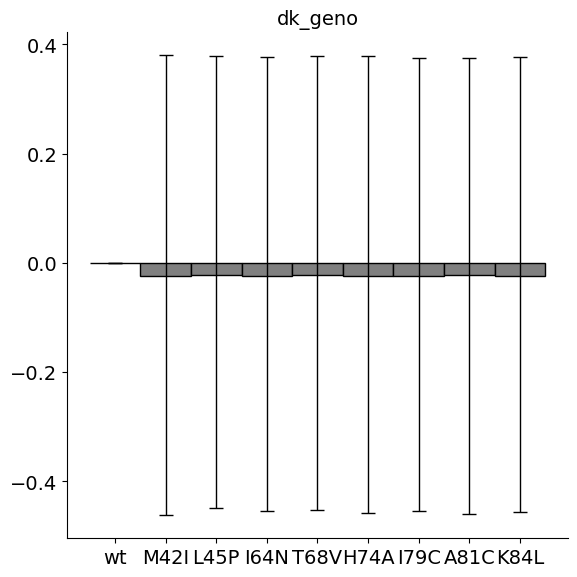

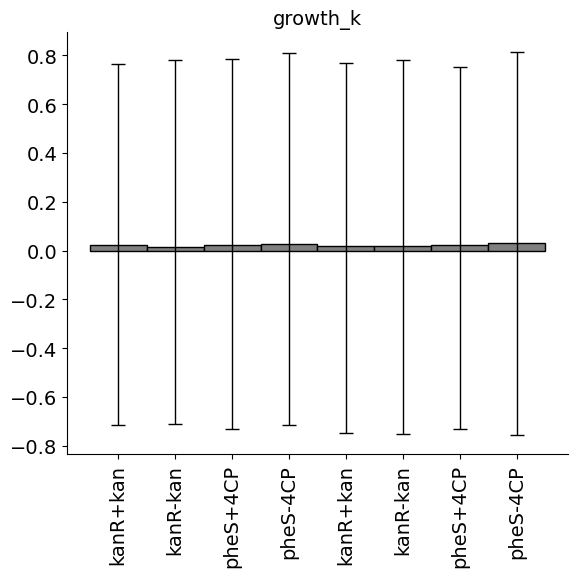

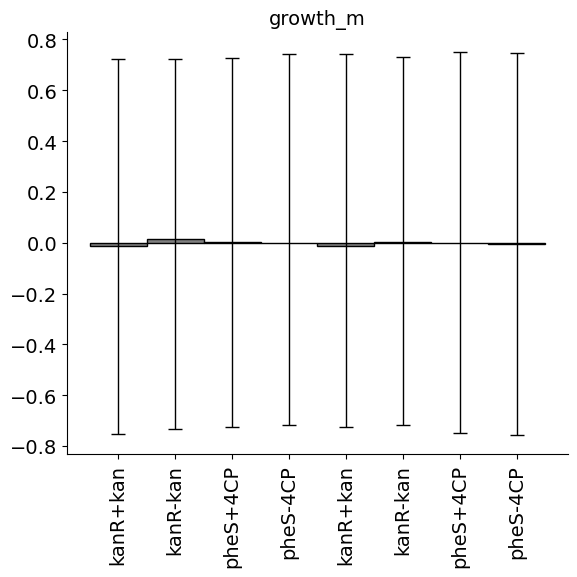

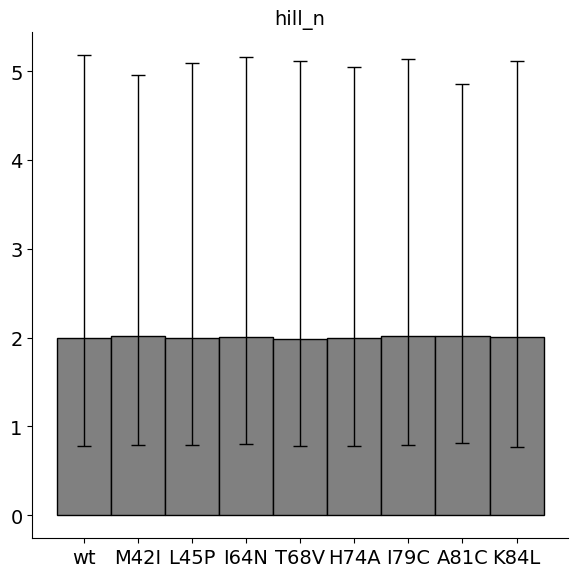

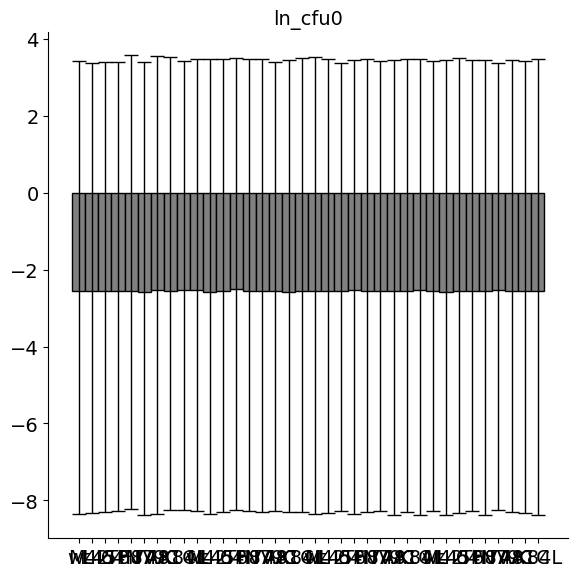

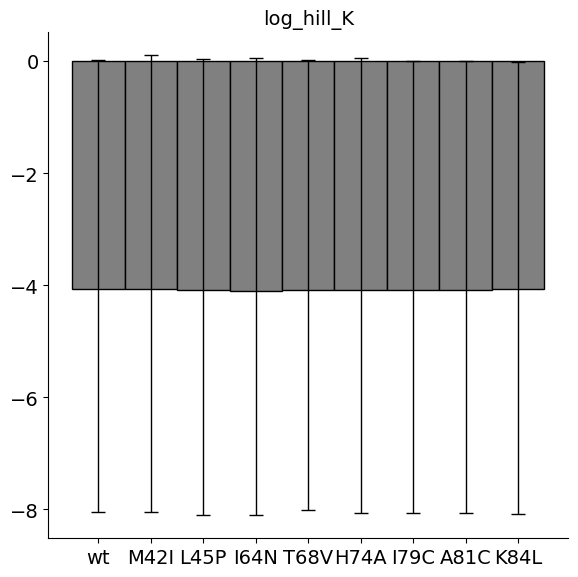

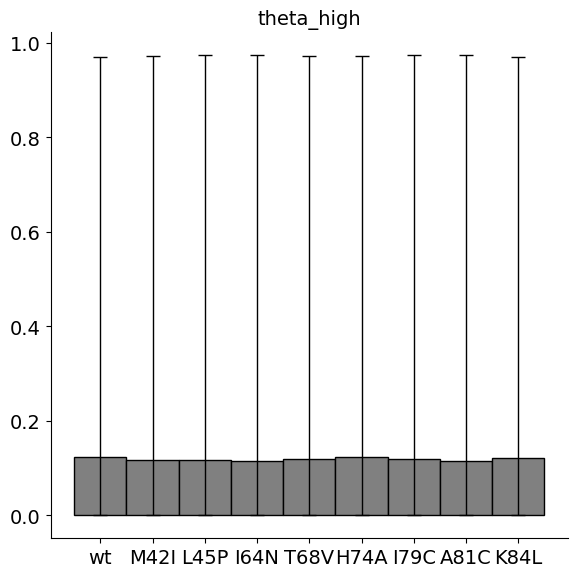

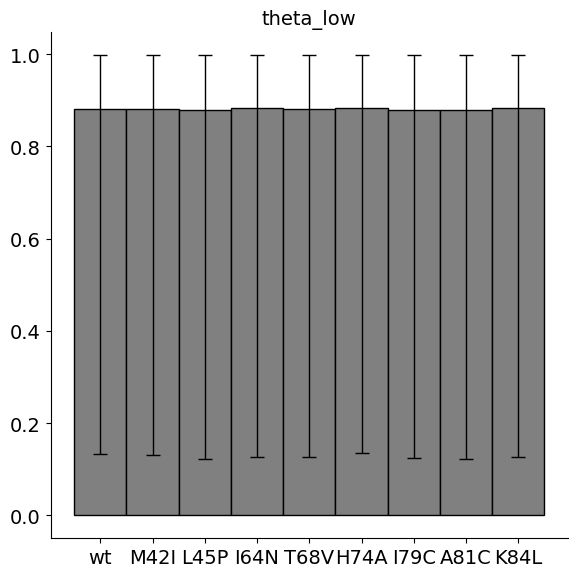

In [12]:
def plot_fit_param(df,title=None,ax=None):

    if ax is None:
        fig, ax = plt.subplots(1,figsize=(6,6))

    x = np.arange(len(df))
    y = df["median"]
    y_low_95 = y - df["lower_95"]
    y_low_std = y - df["lower_std"]
    y_high_std = df["upper_std"] - y
    y_high_95 = df["upper_95"] - y

    for i in range(len(x)):
        ax.fill([x[i],x[i],x[i]+1,x[i]+1],
                [0   ,y[i],y[i]  ,0],
                facecolor='gray',edgecolor='black')
    ax.errorbar(x=x+0.5,
                 y=y,
                 yerr=[y_low_95,y_high_95],
                 lw=0,
                 elinewidth=1,
                 capsize=5,
                 color='black')
    
    ax.set_xticks(x + 0.5)

    if "genotype" in df.columns:
        ax.set_xticklabels(df["genotype"])
    else:
        ax.set_xticklabels(df["condition"])
        ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    fig = ax.get_figure()
    fig.tight_layout()
        

    return fig, ax

param_keys = list(params.keys())
param_keys.sort()
for p in param_keys:

    fig, ax = plot_fit_param(params[p],p)

    
    